In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
!unzip '/content/drive/MyDrive/Projects/Garbage/garbage_dataset.zip' -d '/content/'

In [4]:
data_directory = Path('/content/Garbage/original_images')
image_transformer = T.Compose([T.Resize((32, 32)), T.ToTensor()])
dataset = ImageFolder(data_directory, transform=image_transformer)

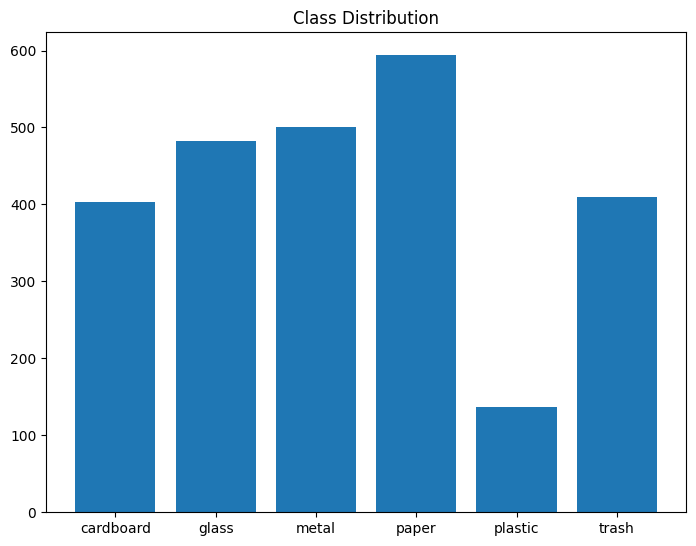

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = []
for i in os.listdir(data_directory):
  counts.append(len(os.listdir(os.path.join(data_directory, i))))

ax.bar(dataset.classes,counts)
plt.title('Class Distribution')
plt.show()

In [6]:
def convert_scale(garbage_class):
  original_images = '/content/Garbage/original_images/'+garbage_class+'/'
  processed_images = '/content/Garbage/processed_images/'+garbage_class+'/'
  images = os.listdir(original_images)
  for imgi in images:
      im = Image.open(os.path.join(original_images, imgi))
      img = im.resize((32,32))
      gray = img.convert('L')
      gray.save(processed_images + imgi, "JPEG")

In [7]:
def preprocess_data():
  class_items = os.listdir(data_directory)
  for cls in class_items:
    convert_scale(cls)


preprocess_data()

In [8]:
def get_image_paths(folder_path, num_samples=5):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(root, filename))
            if len(image_paths) >= num_samples:
                break
    return image_paths

In [9]:
def plot_sample_images(image_paths):
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


In [ ]:
folder_paths = []
for i in os.listdir(data_directory):
  folder_paths.append(os.path.join(data_directory, i))

num_samples = 5
for folder_path in folder_paths:
    image_paths = get_image_paths(folder_path, num_samples)
    plot_sample_images(image_paths)


In [19]:
def plot_sample_images(image_paths):
    plt.figure(figsize=(10, 1))
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


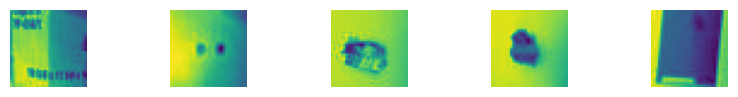

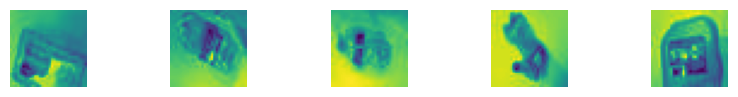

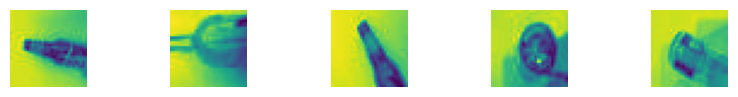

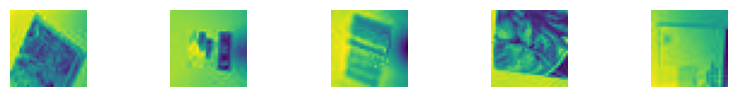

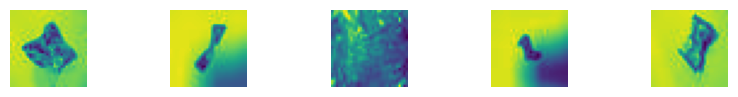

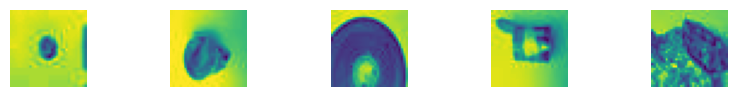

In [20]:
processed_data_directory = Path('/content/Garbage/processed_images')
folder_paths = []
for i in os.listdir(processed_data_directory):
  folder_paths.append(os.path.join(processed_data_directory, i))

num_samples = 5
for folder_path in folder_paths:
    image_paths = get_image_paths(folder_path, num_samples)
    plot_sample_images(image_paths)


In [15]:
train_dir = "/content/Garbage/original_images"
test_dir = '/content/Garbage/processed_images'
class_names = ['cardboard', 'glass', 'metal','paper','plastic','trash']
height, width = 32, 32

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras

In [22]:
image_gen = ImageDataGenerator(rescale=1./255)

In [23]:
train_data_gen = image_gen.flow_from_directory(
    directory = train_dir,
    shuffle=True,
    target_size = (height, width),
    class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    shuffle=True,
    target_size = (height, width),
    class_mode='categorical')

Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


In [24]:
sample_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    shuffle=True,
    target_size = (200, 200),
    class_mode='categorical')

sample_training_images, _= next(sample_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1,4, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Found 2527 images belonging to 6 classes.


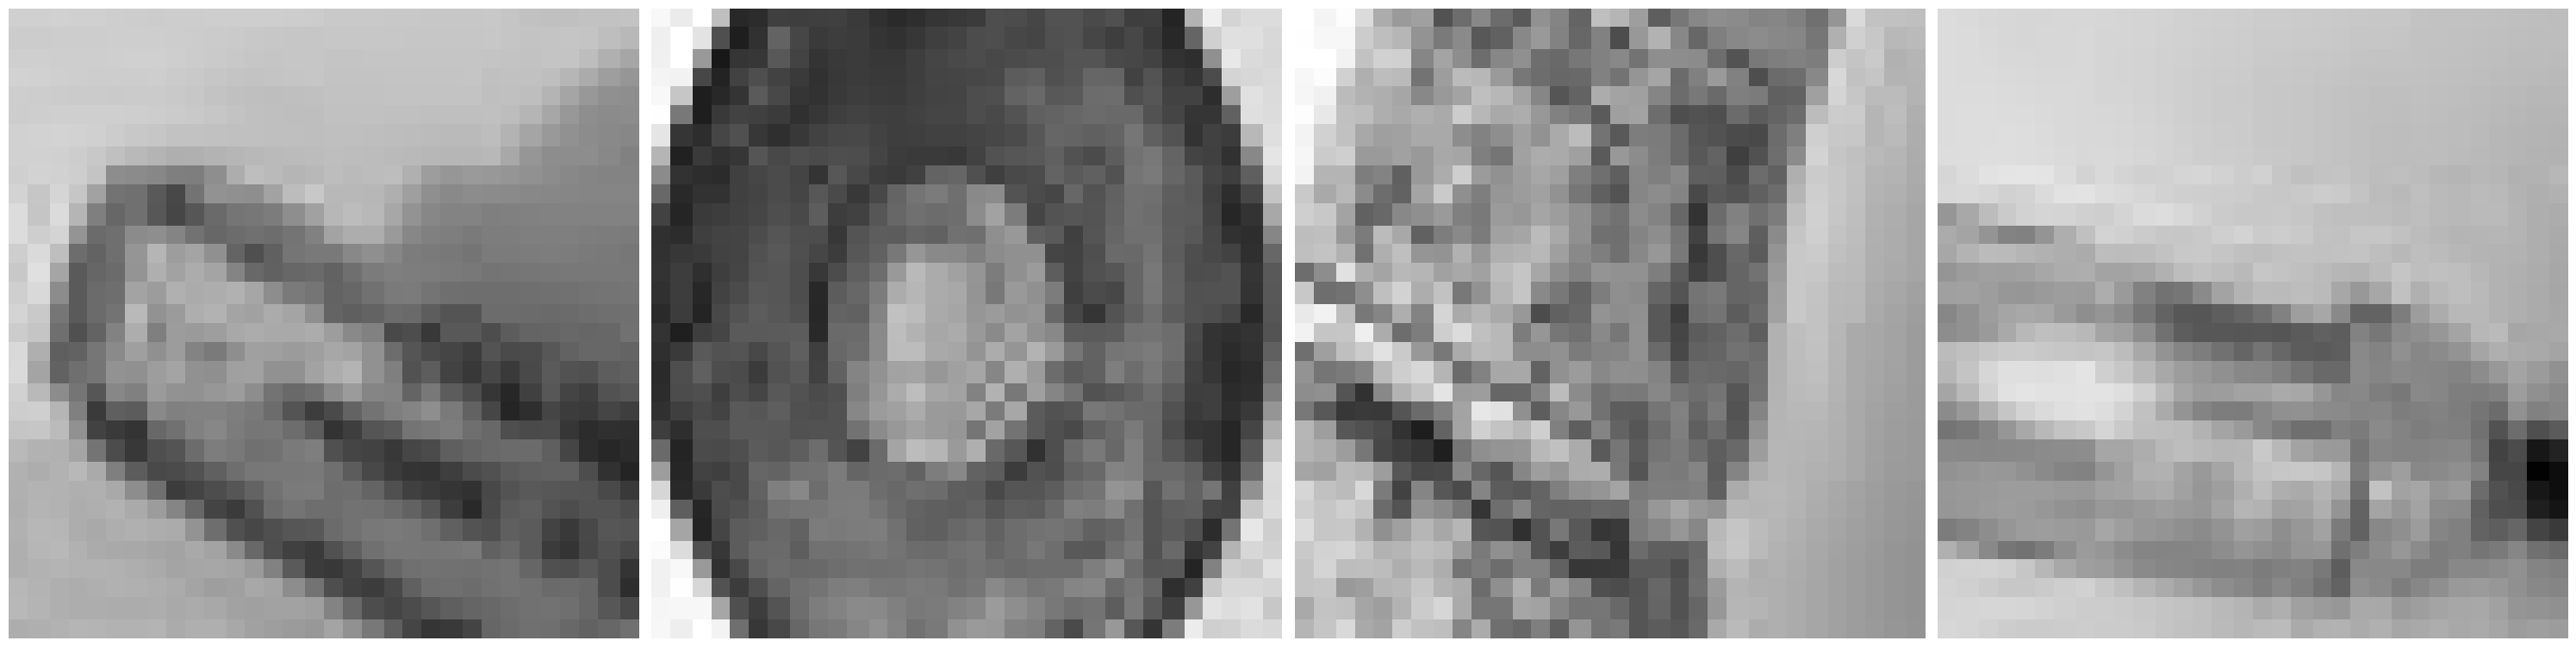

In [25]:
plotImages(sample_training_images[:4])

In [26]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(height,width, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(6, activation='softmax')
])

In [31]:
batch_size = 32
epochs = 50
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [28]:
train_num = sum(counts)
test_num = sum(counts)

In [33]:
history = model.fit(
    train_data_gen,
    validation_data = train_data_gen,
    steps_per_epoch= train_num // batch_size,
    epochs = 10,
    validation_steps= test_num // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=7)]
)

Epoch 1/10
78/78 [==============================] - 26s 331ms/step - loss: 0.7382 - accuracy: 0.7399 - val_loss: 0.6581 - val_accuracy: 0.7632
Epoch 2/10
78/78 [==============================] - 24s 304ms/step - loss: 0.6864 - accuracy: 0.7559 - val_loss: 0.6364 - val_accuracy: 0.7845
Epoch 3/10
78/78 [==============================] - 23s 291ms/step - loss: 0.6700 - accuracy: 0.7523 - val_loss: 0.6777 - val_accuracy: 0.7492
Epoch 4/10
78/78 [==============================] - 33s 430ms/step - loss: 0.6315 - accuracy: 0.7804 - val_loss: 0.6108 - val_accuracy: 0.7808
Epoch 5/10
78/78 [==============================] - 33s 430ms/step - loss: 0.6076 - accuracy: 0.7784 - val_loss: 0.5608 - val_accuracy: 0.8033
Epoch 6/10
78/78 [==============================] - 24s 304ms/step - loss: 0.5928 - accuracy: 0.7944 - val_loss: 0.6895 - val_accuracy: 0.7492
Epoch 7/10
78/78 [==============================] - 22s 289ms/step - loss: 0.5641 - accuracy: 0.7956 - val_loss: 0.4633 - val_accuracy: 0.8409

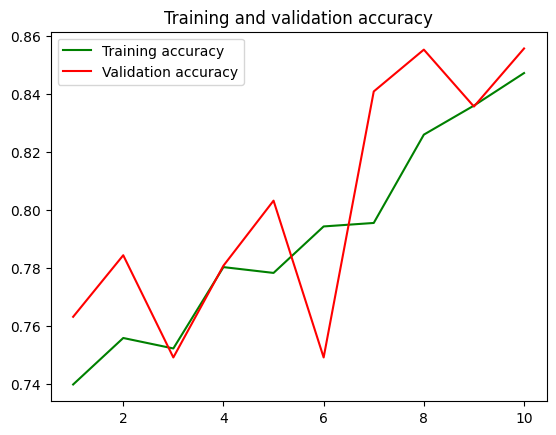

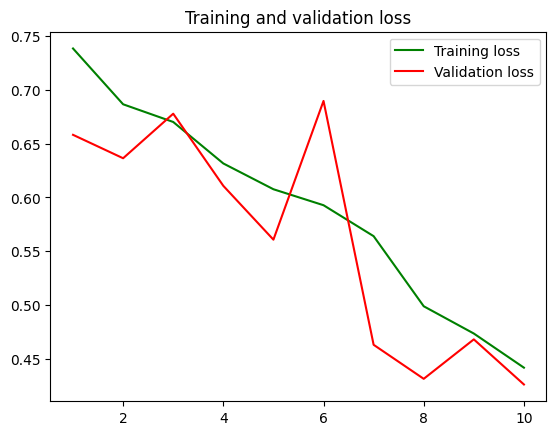

In [36]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
from sklearn.model_selection import train_test_split
(X,y) = (train_data_gen[0], train_data_gen[1])
y_test = train_test_split(X,y,test_size=0.2, random_state=4)

nb_classes = 6
Y_train = model.predict(train_data_gen)
y_train = np.argmax(Y_train, axis=1)
Y_test = model.predict(test_data_gen)
y_test = np.argmax(Y_test, axis=1)

print('Classification Report')
target_names = ['cardboard', 'glass', 'metal','paper','plastic','trash']
print(classification_report(train_data_gen.classes, y_test, target_names=target_names,zero_division=0))

79/79 [==============================] - 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.14      0.07      0.10       403
       glass       0.21      0.36      0.27       501
       metal       0.08      0.02      0.03       410
       paper       0.25      0.47      0.32       594
     plastic       0.18      0.09      0.12       482
       trash       0.00      0.00      0.00       137

    accuracy                           0.21      2527
   macro avg       0.14      0.17      0.14      2527
weighted avg       0.17      0.21      0.17      2527

